In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torchvision import datasets, models, transforms
import os
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset,DataLoader
import random

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# 定义是否使用GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCH = 30   #遍历数据集次数
pre_epoch = 0  # 定义已经遍历数据集的次数
BATCH_SIZE = 10   #批处理尺寸(batch_size)
LR = 0.0001        #学习率

In [3]:
class SiameseNetworkDataset(Dataset):
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset=imageFolderDataset
        self.transform=transform
        self.should_invert=should_invert
        
    def __getitem__(self,index):  #获取图片1、图片2、标签
        img1_folder=random.choice(self.imageFolderDataset.imgs)
        genuine_imposter_ratio=random.randint(0,1)  #随机0或1，真匹配和假匹配概率一样
        if genuine_imposter_ratio:
            while True:
                img2_folder=random.choice(self.imageFolderDataset.imgs)
                if img1_folder[1]==img2_folder[1]:
                    break
        else:
            while True:
                img2_folder=random.choice(self.imageFolderDataset.imgs)
                if img1_folder[1]!=img2_folder[1]:
                    break
                    
        #装换成灰度图            
        img1=Image.open(img1_folder[0])
        img2=Image.open(img2_folder[0])
        img1=img1.convert('RGB')
        img2=img2.convert('RGB')
        
        if self.should_invert:
            img1=Image.ImageOps.invert(img1)
            img2=Image.ImageOps.invert(img2) 
            
        if self.transform is not None:
            img1=self.transform(img1)
            img2=self.transform(img2)  
        #                                    同类为0，不同类为1
        return img1,img2,torch.from_numpy(np.array([int(img1_folder[1]==img2_folder[1])],dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)
    
#定义训练集地址
train_dir='D:/数据库/palmdata/iitd'
batch_size=64

folder_dataset = torchvision.datasets.ImageFolder(root=train_dir)

transform=transforms.Compose([transforms.Resize((128,128)),transforms.ToTensor()])

siamese_dataset=SiameseNetworkDataset(imageFolderDataset=folder_dataset,transform=transform,should_invert=False)

train_dataloader=DataLoader(siamese_dataset,shuffle=True,batch_size=batch_size)

In [4]:
print(next(iter(train_dataloader))[0].shape)  #torch.Size([128, 3, 128, 128])
print(next(iter(train_dataloader))[2].shape)  #torch.Size([128])

torch.Size([64, 3, 128, 128])
torch.Size([64, 1])


In [5]:
class VGGNet(nn.Module):
    def __init__(self, num_classes=460):   # num_classes，此处为 二分类值为2
        super(VGGNet, self).__init__()
        net = models.vgg16(pretrained=True)   # 从预训练模型加载VGG16网络参数
        net.classifier = nn.Sequential()  # 将分类层置空，下面将改变我们的分类层
        self.features = net  # 保留VGG16的特征层
        self.classifier = nn.Sequential(    # 定义自己的分类层
                nn.Linear(512 * 7 * 7, 1024),  #512 * 7 * 7不能改变 ，由VGG16网络决定的，第二个参数为神经元个数可以微调
                nn.ReLU(True),
                nn.Dropout(0.3),
                nn.Linear(1024, 1024),
                nn.ReLU(True),
                nn.Dropout(0.3),
                nn.Linear(1024, num_classes),
        )

    def forward(self, x):
        x = self.features(x) # 预训练提供的提取特征的部分
        x = x.view(x.size(0), -1)
        x = self.classifier(x) # 自定义的分类部分
        return x
net = VGGNet().to(device)
print(net)

VGGNet(
  (features): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace)
      (16): MaxPool2d(kernel_size=2, stride=2

# 冻结解冻层

In [6]:
from collections.abc import Iterable
def set_freeze_by_names(model, layer_names, freeze=True):
    if not isinstance(layer_names, Iterable):
        layer_names = [layer_names]
    for name, child in model.named_children():
        if name not in layer_names:
            continue
        for param in child.parameters():
            param.requires_grad = not freeze

def freeze_by_names(model, layer_names):   #冻结某层
    set_freeze_by_names(model, layer_names, True)

def unfreeze_by_names(model, layer_names):  #解冻某层
    set_freeze_by_names(model, layer_names, False)
    
freeze_by_names(net,['features','avgpool','classifier'])
unfreeze_by_names(net,'classifier')

In [7]:
class Simaenet(nn.Module):
    def __init__(self, fnet):   
        super(Simaenet, self).__init__()
        self.fnet=fnet
        self.dnet=nn.Sequential(    # 定义自己的分类层
                nn.Linear(920, 100),  #512 * 7 * 7不能改变 ，由VGG16网络决定的，第二个参数为神经元个数可以微调
                nn.ReLU(True),
                nn.Linear(100, 1),
                nn.Sigmoid()
        )
    def forward(self,x1,x2):
        self.out1=self.fnet(x1)
        self.out2=self.fnet(x2)
        self.out=torch.cat((self.out1,self.out2),1)
        score=self.dnet(self.out)
        return score
    
Simanet=Simaenet(net).cuda()

In [8]:
optimizer = optim.Adam(Simanet.parameters(), lr=0.0005)
#criterion = nn.MSELoss()
criterion=nn.BCELoss()
criterion.to(device=device)

BCELoss()

# 训练模型

In [9]:
epochs=50
counter = []
loss_history = [] 
iteration_number = 0


#开始训练
for epoch in range(0, EPOCH):
    for i, data in enumerate(train_dataloader, 0):
        img1, img2 , y = data
        #img0维度为torch.Size([32, 1, 100, 100])，32是batch，label为torch.Size([32, 1])
        img1, img2 , y = img1.cuda(), img2.cuda(), y.cuda() #数据移至GPU
        optimizer.zero_grad()
        output=Simanet(img1,img2)
        loss_ = criterion(output, y)
        loss_.backward()
        optimizer.step()
        if i % 10 == 0 :
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_.item())
    print("Epoch number: {} , Current loss: {:.4f}\n".format(epoch,loss_.item()))

Epoch number: 0 , Current loss: 0.7263

Epoch number: 1 , Current loss: 0.7385

Epoch number: 2 , Current loss: 0.6495

Epoch number: 3 , Current loss: 0.5228

Epoch number: 4 , Current loss: 0.4666

Epoch number: 5 , Current loss: 0.6563

Epoch number: 6 , Current loss: 0.5628

Epoch number: 7 , Current loss: 0.5338

Epoch number: 8 , Current loss: 0.4508

Epoch number: 9 , Current loss: 0.6072

Epoch number: 10 , Current loss: 0.5022

Epoch number: 11 , Current loss: 0.5732

Epoch number: 12 , Current loss: 0.5045

Epoch number: 13 , Current loss: 0.5514

Epoch number: 14 , Current loss: 0.3632

Epoch number: 15 , Current loss: 0.3434

Epoch number: 16 , Current loss: 0.4627

Epoch number: 17 , Current loss: 0.4339

Epoch number: 18 , Current loss: 0.5238

Epoch number: 19 , Current loss: 0.3686

Epoch number: 20 , Current loss: 0.4823

Epoch number: 21 , Current loss: 0.4741

Epoch number: 22 , Current loss: 0.4364

Epoch number: 23 , Current loss: 0.3758

Epoch number: 24 , Current

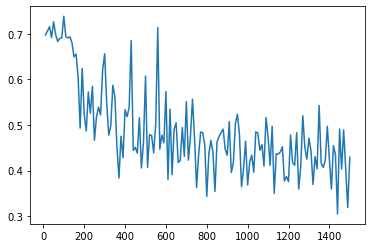

In [10]:
def plot_loss(iteration,loss):
    plt.plot(iteration,loss)        
    plt.show()
    
plot_loss(counter, loss_history)

In [11]:
print(len(counter))

150


# 测试模型

In [12]:
losses=[]
for i, data in enumerate(train_dataloader, 0):
    img1, img2 , y = data
    #img0维度为torch.Size([32, 1, 100, 100])，32是batch，label为torch.Size([32, 1])
    img1, img2 , y = img1.cuda(), img2.cuda(), y.cuda() #数据移至GPU
    output=Simanet(img1,img2)
    loss_ = criterion(output, y)
    if i % 10 == 0 :
            losses.append(loss_.item())
print(sum(losses)/len(losses))

0.4258600413799286


# 可视化

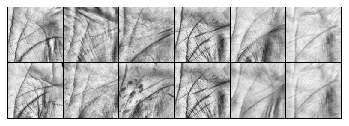

true:
[[0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]]
pre
tensor([0], device='cuda:0', dtype=torch.uint8)
tensor([0], device='cuda:0', dtype=torch.uint8)
tensor([0], device='cuda:0', dtype=torch.uint8)
tensor([0], device='cuda:0', dtype=torch.uint8)
tensor([1], device='cuda:0', dtype=torch.uint8)
tensor([0], device='cuda:0', dtype=torch.uint8)


In [13]:
def show_img(img0,title=None):
    img=img0.numpy()
    plt.axis("off")
    if title:
        plt.text(75, 8, text, style='italic',fontweight='bold',bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(img,(1,2,0)))
    plt.show()

test_dataloader=DataLoader(siamese_dataset,shuffle=True,batch_size=6)
x1,x2,y=next(iter(test_dataloader))
concatenated = torch.cat((x1,x2),0) 
show_img(torchvision.utils.make_grid(concatenated, nrow=6))
print('true:')
print(y.numpy())
      
print('pre')
x1,x2,y=x1.cuda(),x2.cuda(),y.cuda()
output=Simanet(x1,x2)

for i in range(6):
    flag=output[i]>0.66
    print(flag)

# 计算准确率

In [19]:
v_batch_size=32
v_epoch=10
acc=[]

for k in range(v_epoch):
    test_dataloader=DataLoader(siamese_dataset,shuffle=True,batch_size=v_batch_size)
    x1,x2,y=next(iter(test_dataloader))
    true=y.numpy()
    
    x1,x2,y=x1.cuda(),x2.cuda(),y.cuda()
    output=Simanet(x1,x2)
    preds=[]
    for i in range(len(output)):
        flag=output[i]>0.33
        preds.append(flag)
    train_correct = (preds == true.squeeze(1)).sum()
    acc.append(train_correct/len(output))
print(sum(acc)/v_epoch)

0.815625


In [17]:
v_batch_size=32
v_epoch=10
total_acc=[]

for k in range(v_epoch):
    test_dataloader=DataLoader(siamese_dataset,shuffle=True,batch_size=v_batch_size)
    x1,x2,y=next(iter(test_dataloader))
    true=y.numpy()
    
    x1,x2,y=x1.cuda(),x2.cuda(),y.cuda()
    output=Simanet(x1,x2)
    acc=[]
    for t in  np.linspace(0,1,10):
        preds=[]
        for i in range(len(output)):
            flag=output[i]>t
            preds.append(flag)
        train_correct = (preds == true.squeeze(1)).sum()
        acc.append(train_correct/len(output))
    total_acc.append(acc)
print(total_acc)

[[0.53125, 0.8125, 0.8125, 0.8125, 0.75, 0.8125, 0.71875, 0.53125, 0.5, 0.46875], [0.46875, 0.75, 0.78125, 0.84375, 0.84375, 0.84375, 0.90625, 0.6875, 0.5625, 0.53125], [0.375, 0.6875, 0.71875, 0.8125, 0.84375, 0.875, 0.75, 0.78125, 0.625, 0.625], [0.40625, 0.75, 0.8125, 0.84375, 0.84375, 0.8125, 0.78125, 0.6875, 0.625, 0.59375], [0.4375, 0.75, 0.84375, 0.84375, 0.875, 0.875, 0.75, 0.6875, 0.625, 0.5625], [0.5, 0.875, 0.875, 0.84375, 0.84375, 0.84375, 0.8125, 0.625, 0.53125, 0.5], [0.5, 0.75, 0.8125, 0.84375, 0.84375, 0.78125, 0.65625, 0.65625, 0.53125, 0.5], [0.53125, 0.6875, 0.75, 0.75, 0.6875, 0.59375, 0.5625, 0.5, 0.53125, 0.46875], [0.46875, 0.78125, 0.8125, 0.8125, 0.8125, 0.8125, 0.71875, 0.5625, 0.5625, 0.53125], [0.5625, 0.6875, 0.8125, 0.84375, 0.8125, 0.78125, 0.71875, 0.53125, 0.46875, 0.4375]]


In [18]:
print(max(total_acc))
print(np.linspace(0,1,10))

[0.5625, 0.6875, 0.8125, 0.84375, 0.8125, 0.78125, 0.71875, 0.53125, 0.46875, 0.4375]
[0.         0.11111111 0.22222222 0.33333333 0.44444444 0.55555556
 0.66666667 0.77777778 0.88888889 1.        ]
